In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import re
import string
import random

In [4]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [5]:
with open("/kaggle/input/games-of-thrones/game_of_thrones.txt" , 'r') as file:
    text = file.readlines()


In [6]:
text[:2]

['A Song of Ice and Fire\n', '\n']

In [7]:
corpus = []
for line in text:
    temp = line.split('.')
    for something in temp:
        corpus.append(something)

In [8]:
data = set(corpus)

In [9]:
dataset = pd.DataFrame(data,  columns=["text"] )

In [10]:
dataset = dataset[dataset['text'].map(lambda x: len(x.split()) > 2)]

In [11]:
dataset.shape

(23143, 1)

In [12]:
dataset.head()

,text
1,"If you knew what the oath would cost you, yo..."
2,"You sent for me, my lord Hand? \n"
3,Viserys smiled and lowered his sword
4,The tom bounded off in the blink of an eye
5,You'll be sewing all through winter


In [13]:
def refine(text):
    text = text.lower()
    text = re.sub(re.compile('https?://\S+|www\.\S+|\d+|<.*?>'), '', text)
    text = nltk.word_tokenize(text)
    return (' '.join(text))

In [14]:
dataset['text'] = dataset['text'].apply(refine)

In [15]:
processed_data = dataset.copy()

In [16]:
dataset

,text
1,"if you knew what the oath would cost you , you..."
2,"you sent for me , my lord hand ?"
3,viserys smiled and lowered his sword
4,the tom bounded off in the blink of an eye
5,you 'll be sewing all through winter
...,...
23854,"the wolf glanced up from time to time , eyes s..."
23855,"summer , to me , bran called"
23856,the other slid forward on silent feet
23857,"stannis baratheon is robert 's true heir , ned..."


In [17]:
dataset['text'] = dataset['text'].map(lambda x: 'sos ' + x + ' eos')

In [18]:
dataset

,text
1,"sos if you knew what the oath would cost you ,..."
2,"sos you sent for me , my lord hand ? eos"
3,sos viserys smiled and lowered his sword eos
4,sos the tom bounded off in the blink of an eye...
5,sos you 'll be sewing all through winter eos
...,...
23854,"sos the wolf glanced up from time to time , ey..."
23855,"sos summer , to me , bran called eos"
23856,sos the other slid forward on silent feet eos
23857,"sos stannis baratheon is robert 's true heir ,..."


In [19]:
sent_len = dataset['text'].map(lambda x: len(x.split()))

In [20]:
max(sent_len)

135

In [21]:
def tokenization(text):
    tokens = Tokenizer()
    tokens.fit_on_texts(text)
    input_seq = tokens.texts_to_sequences(text)

    return input_seq, tokens

In [22]:
features, tokens = tokenization(dataset['text'])

In [23]:
features[:5]

[[1,
  45,
  12,
  166,
  53,
  3,
  2240,
  37,
  3311,
  12,
  12,
  158,
  39,
  509,
  2551,
  5,
  1009,
  3,
  1137,
  132,
  2],
 [1, 12, 292, 25, 44, 31, 32, 72, 2],
 [1, 344, 428, 4, 839, 9, 123, 2],
 [1, 3, 1195, 1718, 85, 13, 3, 2104, 7, 86, 596, 2],
 [1, 12, 143, 39, 5870, 40, 119, 668, 2]]

In [24]:
vocab = len(tokens.word_index) + 1
vocab

11793

In [25]:
input_feature = [x[:-1] for x in features]
input_feature[:3]

[[1,
  45,
  12,
  166,
  53,
  3,
  2240,
  37,
  3311,
  12,
  12,
  158,
  39,
  509,
  2551,
  5,
  1009,
  3,
  1137,
  132],
 [1, 12, 292, 25, 44, 31, 32, 72],
 [1, 344, 428, 4, 839, 9, 123]]

In [26]:
output_feature = [x[1:] for x in features]
output_feature[:3]

[[45,
  12,
  166,
  53,
  3,
  2240,
  37,
  3311,
  12,
  12,
  158,
  39,
  509,
  2551,
  5,
  1009,
  3,
  1137,
  132,
  2],
 [12, 292, 25, 44, 31, 32, 72, 2],
 [344, 428, 4, 839, 9, 123, 2]]

In [27]:
seq_len = 60

In [28]:
def pad(seq):
    padded = pad_sequences(seq, padding = 'post', maxlen=seq_len)
    padded = tf.convert_to_tensor(padded)
    return padded

In [29]:
input_data = pad(input_feature)
input_data

<tf.Tensor: shape=(23143, 60), dtype=int32, numpy=
array([[  1,  45,  12, ...,   0,   0,   0],
       [  1,  12, 292, ...,   0,   0,   0],
       [  1, 344, 428, ...,   0,   0,   0],
       ...,
       [  1,   3, 150, ...,   0,   0,   0],
       [  1, 452, 531, ...,   0,   0,   0],
       [  1,  89,   3, ...,   0,   0,   0]], dtype=int32)>

In [30]:
output_data = pad(output_feature)
output_data

<tf.Tensor: shape=(23143, 60), dtype=int32, numpy=
array([[ 45,  12, 166, ...,   0,   0,   0],
       [ 12, 292,  25, ...,   0,   0,   0],
       [344, 428,   4, ...,   0,   0,   0],
       ...,
       [  3, 150, 622, ...,   0,   0,   0],
       [452, 531,  29, ...,   0,   0,   0],
       [ 89,   3, 813, ...,   0,   0,   0]], dtype=int32)>

In [31]:
vocab = vocab
seq_len = input_data.shape[1]
embed_dim = 120
hidden_dim = 128
num_heads = 4
num_blocks = 4
head_dim = embed_dim//num_heads

In [32]:
class positionalEncoding(tf.keras.layers.Layer):
    def __init__(self, vocab, sequence, embed_dim, **kwargs):
        super().__init__(**kwargs)

        self.vocab = vocab
        self.sequence = sequence
        self.embed_dim = embed_dim
        self.embeddings = tf.keras.layers.Embedding(input_dim = self.vocab, output_dim = self.embed_dim, input_length = self.sequence)
        self.positional_encoding = tf.keras.layers.Embedding(self.sequence, self.embed_dim)

    def call(self, inputs):
        pos_ids = tf.range(self.sequence)
        embedded = self.embeddings(inputs)
        position = self.positional_encoding(pos_ids)
        final = embedded + position

        return final

In [33]:
ps = positionalEncoding(vocab, seq_len, embed_dim)
input_embed = ps(input_data)

In [34]:
input_embed

<tf.Tensor: shape=(23143, 60, 120), dtype=float32, numpy=
array([[[ 1.79170370e-02, -5.33219241e-02, -1.68120824e-02, ...,
          5.66147789e-02, -6.97407499e-03, -2.42577903e-02],
        [-1.26602985e-02,  2.19419599e-06, -1.02952868e-03, ...,
         -3.93852852e-02,  1.37026273e-02,  3.78266945e-02],
        [-1.91043988e-02, -6.38152286e-03,  3.75364423e-02, ...,
          1.93515308e-02,  1.01768728e-02, -4.70708013e-02],
        ...,
        [-1.45688690e-02, -2.05075517e-02, -7.45885447e-03, ...,
          2.57075205e-03,  1.95367448e-03,  7.82858953e-03],
        [ 7.72630423e-02, -3.72617394e-02,  2.27426030e-02, ...,
          2.33751088e-02,  7.11224377e-02,  2.04807632e-02],
        [-1.64385363e-02,  3.16037871e-02,  1.41032077e-02, ...,
         -1.72838569e-04,  8.44435953e-03,  5.50416112e-02]],

       [[ 1.79170370e-02, -5.33219241e-02, -1.68120824e-02, ...,
          5.66147789e-02, -6.97407499e-03, -2.42577903e-02],
        [-1.79739222e-02, -1.94559321e-02, -6

In [35]:
class causal_masking(tf.keras.layers.Layer):

    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

    def call(self, sequence):
        mask = tf.linalg.band_part(tf.ones((1, sequence, sequence)), -1, 0)
        return mask

In [36]:
cm = causal_masking()
mask = cm(seq_len)

In [37]:
mask

<tf.Tensor: shape=(1, 60, 60), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

In [38]:
class decoder_block(tf.keras.layers.Layer):

    def __init__(self, num_heads, vocab, sequence, embed_dim, hidden_dim, dropout_rate = 0.01, **kwargs):
        super().__init__(**kwargs)

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads, embed_dim, dropout = dropout_rate)
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.drop1 = tf.keras.layers.Dropout(rate = dropout_rate)
        self.drop2 = tf.keras.layers.Dropout(rate = dropout_rate)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim,activation="relu"),
                                    tf.keras.layers.Dense(hidden_dim,activation="relu"),
                                    tf.keras.layers.Dense(embed_dim,activation="relu"),
                                    tf.keras.layers.Dropout(dropout_rate)])

    def call(self, inputs, mask, training = True):

        mha_out = self.mha(inputs, inputs, inputs, mask)
        drop1 = self.drop1(mha_out, training = training)
        norm1 = self.norm1(inputs + drop1)

        ffn_out = self.ffn(norm1)
        drop2 = self.drop2(ffn_out, training = training)
        norm2 = self.norm2(norm1 +  drop2)

        return norm2

In [39]:
class decoder(tf.keras.layers.Layer):

    def __init__(self, num_heads, vocab, sequence, embed_dim, hidden_dim, num_blocks, dropout_rate = 0.01, **kwargs):
        super().__init__()

        self.sequence = sequence
        self.pos_enc = positionalEncoding(vocab, sequence, embed_dim)
        self.masking = causal_masking()
        self.decoder = [decoder_block(num_heads, vocab, sequence, embed_dim, hidden_dim) for i in range(num_blocks)]
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        emb = self.pos_enc(inputs)
        masked = self.masking(self.sequence)
        temp = emb

        for blocks in self.decoder:
            emb = blocks(emb, masked)
            emb = self.add([temp, emb])
            temp = emb

        return emb

In [40]:
class gpt_model(tf.keras.Model):

    def __init__(self,num_heads, vocab, sequence, embed_dim, hidden_dim, num_blocks, **kwargs):
        super().__init__(**kwargs)

        self.decoder = decoder(num_heads, vocab, sequence, embed_dim, hidden_dim, num_blocks)

        self.final_layer = tf.keras.layers.Dense(vocab, activation='relu')
        self.softmax = tf.keras.layers.Softmax(axis = -1)

    def call(self, inputs):

        dec_out = self.decoder(inputs)

        densed = self.final_layer(dec_out)
        softmaxed = self.softmax(densed)

        return softmaxed

In [41]:
gpt = gpt_model(num_heads, vocab, seq_len, embed_dim, hidden_dim, num_blocks)
gpt_out = gpt(input_data[:1])

In [42]:
gpt.summary()

Model: "gpt_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder (decoder)           multiple                  2542040   
                                                                 
 dense_12 (Dense)            multiple                  1426953   
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 3,968,993
Trainable params: 3,968,993
Non-trainable params: 0
_________________________________________________________________


In [43]:
comp = gpt.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

In [44]:
calls = tf.keras.callbacks.EarlyStopping(patience = 5, verbose = True)

In [45]:
fit = gpt.fit(input_data, output_data , epochs=50, batch_size=32, verbose=True, callbacks=calls)

Epoch 1/50
724/724 [==============================] - 74s 79ms/step - loss: 1.5174 - accuracy: 0.7989
Epoch 2/50
724/724 [==============================] - 33s 45ms/step - loss: 1.3588 - accuracy: 0.8090
Epoch 3/50
724/724 [==============================] - 32s 44ms/step - loss: 1.3180 - accuracy: 0.8129
Epoch 4/50
724/724 [==============================] - 32s 45ms/step - loss: 1.2887 - accuracy: 0.8162
Epoch 5/50
724/724 [==============================] - 32s 44ms/step - loss: 1.2645 - accuracy: 0.8190
Epoch 6/50
724/724 [==============================] - 31s 43ms/step - loss: 1.2411 - accuracy: 0.8223
Epoch 7/50
724/724 [==============================] - 31s 43ms/step - loss: 1.2092 - accuracy: 0.8260
Epoch 8/50
724/724 [==============================] - 31s 43ms/step - loss: 1.1805 - accuracy: 0.8292
Epoch 9/50
724/724 [==============================] - 31s 43ms/step - loss: 1.1619 - accuracy: 0.8323
Epoch 10/50
724/724 [==============================] - 30s 42ms/step - loss: 1.145

In [46]:
fit = gpt.fit(input_data, output_data , epochs=10, batch_size=32, verbose=True, callbacks=calls)

Epoch 1/10
724/724 [==============================] - 30s 42ms/step - loss: 0.9522 - accuracy: 0.8708
Epoch 2/10
724/724 [==============================] - 30s 42ms/step - loss: 0.9532 - accuracy: 0.8705
Epoch 3/10
724/724 [==============================] - 30s 42ms/step - loss: 0.9487 - accuracy: 0.8716
Epoch 4/10
724/724 [==============================] - 30s 42ms/step - loss: 0.9459 - accuracy: 0.8721
Epoch 5/10
724/724 [==============================] - 30s 42ms/step - loss: 0.9432 - accuracy: 0.8724
Epoch 6/10
724/724 [==============================] - 30s 42ms/step - loss: 0.9428 - accuracy: 0.8725
Epoch 7/10
724/724 [==============================] - 31s 42ms/step - loss: 0.9409 - accuracy: 0.8727
Epoch 8/10
724/724 [==============================] - 30s 41ms/step - loss: 0.9390 - accuracy: 0.8733
Epoch 9/10
724/724 [==============================] - 30s 42ms/step - loss: 0.9461 - accuracy: 0.8717
Epoch 10/10
724/724 [==============================] - 30s 42ms/step - loss: 0.936

In [47]:
fit = gpt.fit(input_data, output_data , epochs=20, batch_size=32, verbose=True, callbacks=calls)

Epoch 1/20
724/724 [==============================] - 30s 41ms/step - loss: 0.9358 - accuracy: 0.8738
Epoch 2/20
724/724 [==============================] - 30s 42ms/step - loss: 0.9330 - accuracy: 0.8745
Epoch 3/20
724/724 [==============================] - 30s 42ms/step - loss: 0.9310 - accuracy: 0.8748
Epoch 4/20
724/724 [==============================] - 30s 42ms/step - loss: 0.9309 - accuracy: 0.8748
Epoch 5/20
724/724 [==============================] - 30s 41ms/step - loss: 0.9299 - accuracy: 0.8749
Epoch 6/20
724/724 [==============================] - 30s 41ms/step - loss: 0.9286 - accuracy: 0.8754
Epoch 7/20
724/724 [==============================] - 30s 41ms/step - loss: 0.9273 - accuracy: 0.8756
Epoch 8/20
724/724 [==============================] - 30s 41ms/step - loss: 0.9253 - accuracy: 0.8759
Epoch 9/20
724/724 [==============================] - 30s 42ms/step - loss: 0.9261 - accuracy: 0.8757
Epoch 10/20
724/724 [==============================] - 30s 42ms/step - loss: 0.922

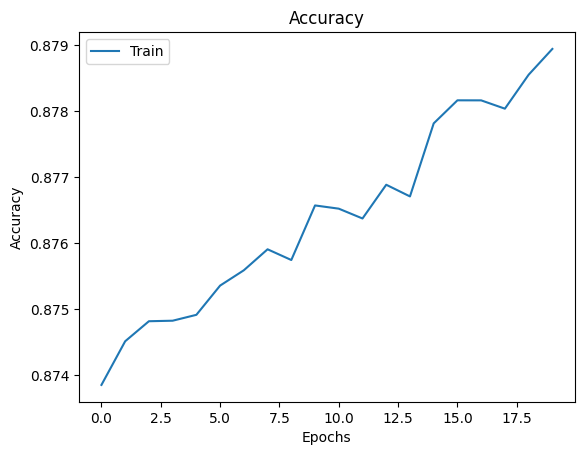

In [55]:
plt.plot(fit.history['accuracy'])
plt.title('Accuracy')
plt.legend(['Train'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

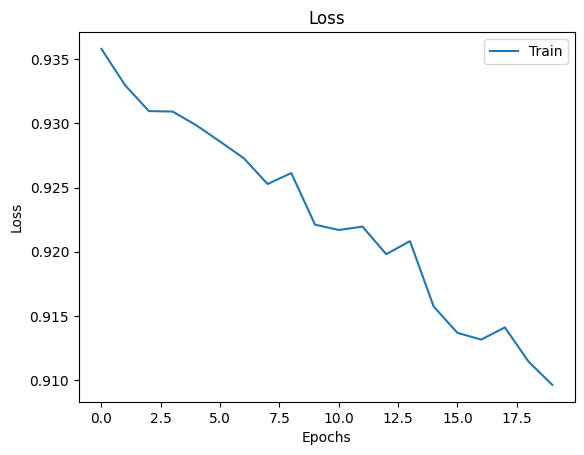

In [54]:
plt.plot(fit.history['loss'])
plt.title('Loss')
plt.legend(['Train'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [48]:
gpt.save_weights("tg_model")

In [51]:
def prepare_inputs(sentences):
    input_tokenized = tokens.texts_to_sequences(sentences)
    input_padded = pad(input_tokenized)
    return input_padded

In [52]:
end = ["<EOS>"]
end = tokens.texts_to_sequences(end)
end = tf.convert_to_tensor(end)
end = end[0]
end

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>

In [73]:
d = ["sos let it"]
dt = prepare_inputs(d)
pred = np.argmax(gpt.predict(dt, verbose=0), axis = -1)[0,0]
d[0] = d[0] + " " + (tokens.sequences_to_texts(np.array([[pred]])))[0]

for i in range(1, seq_len):
    dt = prepare_inputs(d)
    pred = np.argmax(gpt.predict(dt, verbose=0), axis = -1)[0,i]
    d[0] = d[0] + " " + (tokens.sequences_to_texts(np.array([[pred]])))[0]
    print(" ".join(d))
    if pred == end:
        break
            

sos let it he them
sos let it he them be
sos let it he them be said
sos let it he them be said eos


# Thanks